In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T121243Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c2f0b58a67bb154ee4c9f95bafdde5f4da47017feb33f7592a5c472e2d6a76eb7dbe03edc02f385e1540dbdc079bfb74ad79aa674725cc7577e5d90c8788e13fd4eade95726be5ac7548540a14c5c020b42986b382de728844bf1d1f1cadc8770f4ae54c451f60a48f8632cd8530cc724abd1f827407ad0a21df17baf78be81ab200441ec7e911c680e8115532a4f13eb05d5b27343bc99c51b413c236ffa86410cf3e5b2685fb08f7213c714a48c6ffa0bb68fced0e5ababb75a9d426f9adf44c23b10b00ab44a7e826853dfd31aa3a7242012f034f400f3f7a2018b5d06296716782e7dc4f07f4e8bab6d7a9664284caa7862be24313a3fc9e7bc4a0a4b62'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [3]:
column_names = [ 'id', 'topic', 'sentiment', 'text']
data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',names = column_names)
data.drop('id',axis = 1,inplace=True)

In [4]:
data.sentiment.value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [5]:
#remove the null values
data.dropna(inplace=True)

In [13]:
#Data Preprocessing
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

!pip install nltk
import nltk
nltk.download('stopwords') # Download the stopwords corpus

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

#Function to preprocess text
def preprocess_text(text):
    #removing the punctuation, numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '',text,re.I|re.A)

    #Convert to lowercase
    text = text.lower()
    #Tokenize the text
    tokens = text.split()

    #Remove the stop words do stemming
    tokens =  [stemmer.stem(word) for word in tokens if word not in stop_words]
    return  ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data['preprocessed_text']=data['text'].apply(preprocess_text)
print(data[['text','preprocessed_text']].head())

                                                text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

           preprocessed_text  
0   im get borderland murder  
1           come border kill  
2     im get borderland kill  
3  im come borderland murder  
4   im get borderland murder  


In [15]:
#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(data['preprocessed_text'])
y = data['sentiment']
print(X.shape,y.shape)

(73996, 5000) (73996,)


Data Validation Decision Tree Model

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='gini',splitter = "random")
clf.fit(X_train,y_train)

DecisionTreeClassifier(splitter='random')

0.7814766430920311


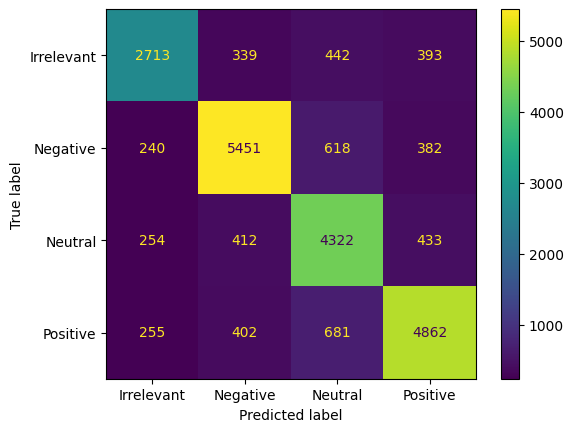

In [18]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [19]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)

    # Transform the preprocessed text into TF-IDF vectors
    X_new = vectorizer.transform([preprocessed_text])

    # Make predictions
    predicted_sentiment = clf.predict(X_new)

    # Print the predicted sentiment
    print("Predicted sentiment:", predicted_sentiment)


In [20]:
predict_sentiment("I am feeling very happy today")

Predicted sentiment: ['Positive']


In [21]:
predict_sentiment("Its beyond me")

Predicted sentiment: ['Neutral']


In [22]:
predict_sentiment("Die you son of something")

Predicted sentiment: ['Neutral']


In [23]:
predict_sentiment("Nvdia is a Giant Company")

Predicted sentiment: ['Negative']
